Look for best hyperparameters : a centralised or decentralised critic, share critic params or not.

In [1]:
%pip install torchrl
%pip install vmas==1.2.11
%pip install tqdm
!sudo apt-get update
!sudo apt-get install -y x11-utils
!sudo apt-get install -y xvfb
%pip install pyvirtualdisplay
!sudo apt-get install -y python3-opengl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease                 
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease               
Hit:4 https://packages.microsoft.com/repos/microsoft-ubuntu-focal-prod focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease               
Hit:6 https://dl.yarnpkg.com/debian stable InRelease                   
Hit:7 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease
Hit:8 https://packagecloud.io/github/git-lfs/ubuntu focal InRelease    
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+5).
0 upgraded, 0 newly installe

In [2]:
# Torch
import torch

from tensordict.nn import TensorDictModule, InteractionType
from tensordict.nn.distributions import NormalParamExtractor

# Tensordict modules
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import SoftUpdate, ValueEstimators
from torchrl.objectives.sac import SACLoss


# Utils
torch.manual_seed(0)
from tqdm import tqdm
import time

In [3]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 20  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate

# SAC
value_loss='smooth_l1' # 'smooth_l1' 'mse' ; loss function to be used with the value function loss
gamma = 0.9  # discount factor
polyak = 0.002 # lambda for generalised advantage estimation

# Model
layers_config = [256, 128, 64]  # Number of units per layer in the network

# VMAS
max_steps = 100  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "navigation"
n_agents = 3  # Number of agents in the scenario
env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    max_steps=max_steps,
    device=vmas_device,
    # Scenario kwargs
    n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
)
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)
check_env_specs(env)
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
time = time.time()
print(time)

2024-02-24 00:21:00,075 [torchrl][INFO] check_env_specs succeeded!


1708734060.2318733


In [4]:
share_parameters_policy = True # whether we want our agents to share the policy parameters.
# On the one hand, sharing parameters means that they will all share the same policy, which will allow them to benefit from each other’s experiences.
# This will also result in faster training. On the other hand, it will make them behaviorally homogenous, as they will in fact share the same model.
centralised_policy = False # wether the policies are centralised (False means each agent will act from its own observation)

In [5]:
def make_policy_module(env, layers_config, device, centralised_policy, share_parameters_policy):
    MultiAgentMultiLayerPerceptron = MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],  # n_obs_per_agent
        n_agent_outputs=2 * env.action_spec.shape[-1],  # 2 * n_actions_per_agents
        n_agents=env.n_agents,
        centralised=centralised_policy,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=len(layers_config),
        num_cells=layers_config,
        activation_class=torch.nn.LeakyReLU,
    )

    policy_net = torch.nn.Sequential(
        MultiAgentMultiLayerPerceptron,
        NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
    )
    policy_module = TensorDictModule(
        policy_net,
        in_keys=[("agents", "observation")],
        out_keys=[("agents", "loc"), ("agents", "scale")],
    )
    policy = ProbabilisticActor(
        module=policy_module,
        spec=env.unbatched_action_spec,
        in_keys=[("agents", "loc"), ("agents", "scale")],
        out_keys=[env.action_key],
        distribution_class=TanhNormal,
        distribution_kwargs={
            "min": env.unbatched_action_spec[env.action_key].space.low,
            "max": env.unbatched_action_spec[env.action_key].space.high,
            "tanh_loc": False,
        },
        default_interaction_type=InteractionType.RANDOM,
        return_log_prob=False,
    )

    return policy

def make_Qval_module(env, layers_config, device, centralised_Qvalues, share_parameters_Qvalues):
    Qval_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1] + env.unbatched_action_spec['agents', 'action'].shape[-1],
        n_agent_outputs=1,  # 1 value per agent
        n_agents=env.n_agents,
        centralised=centralised_Qvalues,
        share_params=share_parameters_Qvalues,
        device=device,
        depth=len(layers_config),
        num_cells=layers_config,
        activation_class=torch.nn.LeakyReLU,

    )

    Qval = TensorDictModule(
        module=Qval_net,
        out_keys=[("agents", "state_action_value")],
        in_keys=[("agents", "observation"), ("agents", "action")],
    )

    return Qval

In [6]:
def make_collector(env, policy, device, storing_device, frames_per_batch, init_random_frames, total_frames):
    return SyncDataCollector(
        env,
        policy,
        device=device,
        storing_device=storing_device,
        frames_per_batch=frames_per_batch,
        init_random_frames=init_random_frames,
        total_frames=total_frames,
    )

def make_replay_buffer(frames_per_batch, minibatch_size, device):
    return ReplayBuffer(
        storage=LazyTensorStorage(
            frames_per_batch, device=device
        ),  # We store the frames_per_batch collected at each iteration
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,  # We will sample minibatches of this size
    )

In [7]:
def make_loss_module(policy, Qval, value_loss, gamma, polyak, lr):
    loss_module = SACLoss(
        actor_network=policy,
        qvalue_network=Qval,
        loss_function=value_loss,
        action_spec=env.action_spec
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)
    target_net_updater = SoftUpdate(loss_module,
                                    eps=polyak)
    optim = torch.optim.Adam(loss_module.parameters(),
                             lr)
    loss_module.set_keys(action=("agents", "action"), 
                        reward=("agents", "episode_reward"),
                        terminated=("next", "agents", "terminated"),
                        done=("agents", "done"),
                        state_action_value=("agents", "state_action_value"),
                        priority=("agents", "td_error"))
    
    return loss_module, target_net_updater, optim

In [8]:
def training_loop(
    env,
    loss_module,
    target_net_updater,
    optim,
    collector,
    replay_buffer,
    n_iters,
    num_epochs,
    frames_per_batch,
    minibatch_size):

    rewards = []
    rewards_eval = []

    # Main loop
    pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

    q_loss = None

    episode_reward_mean_list = []

    for tensordict_data in collector:
        tensordict_data.set(
            ("next", "agents", "done"),
            tensordict_data.get(("next", "done"))
            .unsqueeze(-1)
            .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
        )
        tensordict_data.set(
            ("next", "agents", "terminated"),
            tensordict_data.get(("next", "terminated"))
            .unsqueeze(-1)
            .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
        )
        # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)
        data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data

        data_view.pop(('done'))
        replay_buffer.extend(data_view)

        for _ in range(num_epochs):
            for _ in range(frames_per_batch // minibatch_size):
                subdata = replay_buffer.sample()

                loss_vals = loss_module(subdata)

                loss_value = (
                    loss_vals["loss_actor"]
                    + loss_vals["loss_qvalue"]
                    + loss_vals["loss_alpha"]
                )

                optim.zero_grad()
                loss_value.backward()
                optim.step()

                # update qnet_target params
                target_net_updater.step()

        # update weights of the inference policy
        collector.update_policy_weights_()

        # Logging
        done = tensordict_data.get(("next", "agents", "done"))
        episode_reward_mean = (
            tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
        )
        episode_reward_mean_list.append(episode_reward_mean)
        pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
        pbar.update()

    pbar.close()
    collector.shutdown()
    replay_buffer.empty()
    
    return episode_reward_mean_list

In [9]:
share_parameters_Qvalues_roll = [False]
centralised_Qvalues_roll = [True, False]

store = []
best_policy = None
best_reward = -float("inf")

for share_parameters_Qvalues in share_parameters_Qvalues_roll:
    for centralised_Qvalues in centralised_Qvalues_roll:
        policy = make_policy_module(env, layers_config, device, centralised_policy, share_parameters_policy)
        collector = make_collector(env, policy, device, device, frames_per_batch, init_random_frames=0, total_frames=total_frames)
        replay_buffer = make_replay_buffer(frames_per_batch, minibatch_size, device)
        Qval = make_Qval_module(env, layers_config, device, centralised_Qvalues, share_parameters_Qvalues)
        loss_module, target_net_updater, optim = make_loss_module(policy, Qval, value_loss, gamma, polyak, lr)
        episode_reward_mean_list = training_loop(env, loss_module, target_net_updater, optim, collector, replay_buffer, n_iters, num_epochs, frames_per_batch, minibatch_size)
        print(f"share_parameters_Qvalues: {share_parameters_Qvalues}, centralised_Qvalues: {centralised_Qvalues}, last_episode_reward_mean_list: {episode_reward_mean_list[-1]}")
        store.append((share_parameters_Qvalues, centralised_Qvalues, episode_reward_mean_list))
        if episode_reward_mean_list[-1] > best_reward:
            best_policy = policy
            best_reward = episode_reward_mean_list[-1]

/home/codespace/.python/current/lib/python3.10/site-packages/torchrl/objectives/utils.py:313: UserWarning: Found an eps value < 0.5, which is unexpected. You may want to use the `tau` keyword argument instead.
  warnings.warn(
episode_reward_mean = 1.5762397050857544: 100%|██████████| 20/20 [11:43<00:00, 35.20s/it]  


share_parameters_Qvalues: False, centralised_Qvalues: True, last_episode_reward_mean_list: 1.5762397050857544


episode_reward_mean = 1.7277417182922363: 100%|██████████| 20/20 [11:17<00:00, 33.86s/it] 

share_parameters_Qvalues: False, centralised_Qvalues: False, last_episode_reward_mean_list: 1.7277417182922363


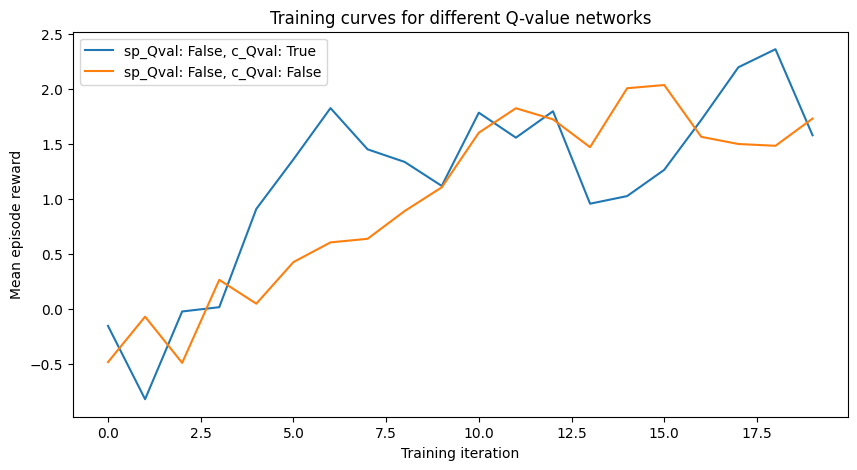

In [10]:
from matplotlib import pyplot as plt

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for share_parameters_Qvalues, centralised_Qvalues, episode_reward_mean_list in store:
    ax.plot(episode_reward_mean_list, label=f"sp_Qval: {share_parameters_Qvalues}, c_Qval: {centralised_Qvalues}")
ax.legend()
ax.set_xlabel("Training iteration")
ax.set_ylabel("Mean episode reward")
ax.set_title("Training curves for different Q-value networks")
plt.savefig('Episode reward mean', format='png')
plt.show()


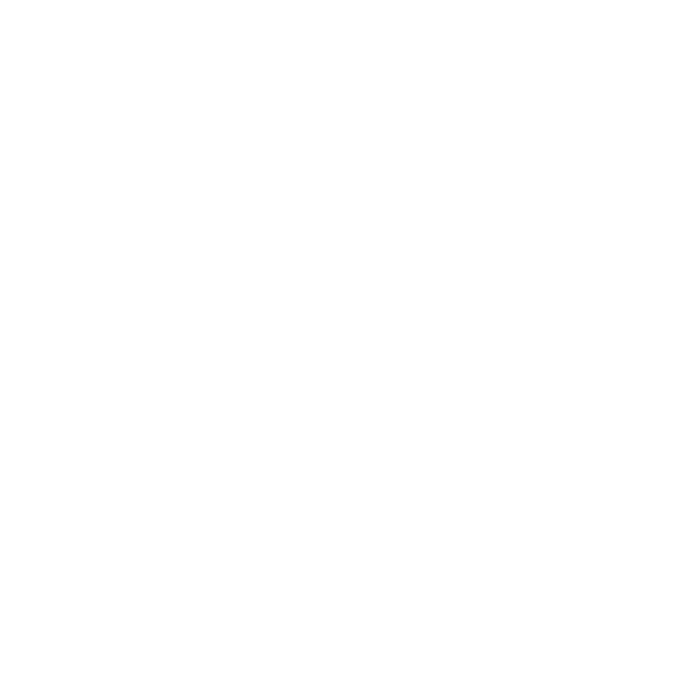

In [11]:
import pyvirtualdisplay
from PIL import Image

display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

def rendering_callback(env, td):
    env.frames.append(Image.fromarray(env.render(mode="rgb_array")))
env.frames = []
with torch.no_grad():
   env.rollout(
       max_steps=max_steps,
       policy=best_policy,
       callback=rendering_callback,
       auto_cast_to_device=True,
       break_when_any_done=False,
   )
env.frames[0].save(
    f"{scenario_name+'best_policy'+str(time)}.gif",
    save_all=True,
    append_images=env.frames[1:],
   duration=3,
   loop=0,
)

from IPython.display import Image
Image(open(f"{scenario_name+'best_policy'+str(time)}.gif", "rb").read())